In [4]:

## Data Collection

import requests
import pandas as pd
from datetime import datetime

# Show all dataframe columns & full text
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# ========== Step 1: Fetch SpaceX Launch Data ==========
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
launches = response.json()

# Convert to DataFrame
data = pd.json_normalize(launches)

# Keep only relevant columns
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# Remove rows with multiple cores/payloads
data = data[data['cores'].map(len) == 1]
data = data[data['payloads'].map(len) == 1]

# Extract single values from list
data['cores'] = data['cores'].map(lambda x: x[0])
data['payloads'] = data['payloads'].map(lambda x: x[0])

# Convert date & restrict to Nov 13, 2020
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime(2020, 11, 13).date()]

# ========== Step 2: Define Helper Functions ==========

def getBoosterVersion(data):
    """Fetch booster version name from rocket ID"""
    versions = []
    for rocket_id in data['rocket']:
        r = requests.get(f"https://api.spacexdata.com/v4/rockets/{rocket_id}").json()
        versions.append(r['name'])
    return versions

def getLaunchSite(data):
    """Fetch launch site details (name, lon, lat)"""
    sites, longitudes, latitudes = [], [], []
    for site_id in data['launchpad']:
        r = requests.get(f"https://api.spacexdata.com/v4/launchpads/{site_id}").json()
        sites.append(r['name'])
        longitudes.append(r['longitude'])
        latitudes.append(r['latitude'])
    return sites, longitudes, latitudes

def getPayloadData(data):
    """Fetch payload mass and orbit"""
    masses, orbits = [], []
    for payload_id in data['payloads']:
        r = requests.get(f"https://api.spacexdata.com/v4/payloads/{payload_id}").json()
        masses.append(r['mass_kg'])
        orbits.append(r['orbit'])
    return masses, orbits

def getCoreData(data):
    """Fetch core details (block, reuse, landing, etc.)"""
    outcome, flights, gridfins, reused, legs, landpads = [], [], [], [], [], []
    blocks, reuse_count, serials = [], [], []
    for core in data['cores']:
        if core['core']:
            r = requests.get(f"https://api.spacexdata.com/v4/cores/{core['core']}").json()
            blocks.append(r.get('block'))
            reuse_count.append(r.get('reuse_count'))
            serials.append(r.get('serial'))
        else:
            blocks.append(None)
            reuse_count.append(None)
            serials.append(None)
        outcome.append(str(core['landing_success']) + ' ' + str(core['landing_type']))
        flights.append(core['flight'])
        gridfins.append(core['gridfins'])
        reused.append(core['reused'])
        legs.append(core['legs'])
        landpads.append(core['landpad'])
    return outcome, flights, gridfins, reused, legs, landpads, blocks, reuse_count, serials

# ========== Step 3: Extract Details with API Calls ==========

BoosterVersion = getBoosterVersion(data)
LaunchSite, Longitude, Latitude = getLaunchSite(data)
PayloadMass, Orbit = getPayloadData(data)
Outcome, Flights, GridFins, Reused, Legs, LandingPad, Block, ReusedCount, Serial = getCoreData(data)

# ========== Step 4: Create Clean DataFrame ==========

launch_dict = {
    'FlightNumber': list(data['flight_number']),
    'Date': list(data['date']),
    'BoosterVersion': BoosterVersion,
    'PayloadMass': PayloadMass,
    'Orbit': Orbit,
    'LaunchSite': LaunchSite,
    'Outcome': Outcome,
    'Flights': Flights,
    'GridFins': GridFins,
    'Reused': Reused,
    'Legs': Legs,
    'LandingPad': LandingPad,
    'Block': Block,
    'ReusedCount': ReusedCount,
    'Serial': Serial,
    'Longitude': Longitude,
    'Latitude': Latitude
}

df = pd.DataFrame(launch_dict)

# ========== Step 5: Keep Only Falcon 9 Launches ==========

data_falcon9 = df[df['BoosterVersion'] != 'Falcon 1'].reset_index(drop=True)
data_falcon9['FlightNumber'] = range(1, len(data_falcon9) + 1)

# ========== Step 6: Clean Payload Mass ==========
# Replace NaN with mean
data_falcon9['PayloadMass'] = pd.to_numeric(data_falcon9['PayloadMass'], errors='coerce')
payload_mean = data_falcon9['PayloadMass'].mean()
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(payload_mean)

# Final Cleaned Data
print(data_falcon9.head())
print("\nMissing values after cleaning:\n", data_falcon9.isnull().sum())


   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6123.547647   LEO  CCSFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCSFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCSFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False       None    1.0   
1    None None        1     False   False  False       None    1.0   
2    None None        1     False   False  False       None    1.0   
3  False Ocean        1     False   False  False       None    1.0   
4    None None        1     False   False  False       None    1.0   

   ReusedCount Serial   Longitude   Latitude  
0            0  B0003  -80.577366  28.561857  
1         

In [5]:
##DATA WRANGLING

import pandas as pd
import numpy as np


df = data_falcon9.copy()   

# Show first 5 rows
print(df.head())

# Check missing values %
print("\nMissing values (%):")
print(df.isnull().mean() * 100)

# Show data types
print("\nData types:")
print(df.dtypes)

# Count launches at each site
print("\nLaunches per Site:")
print(df['LaunchSite'].value_counts())

# Count launches per Orbit (except GTO)
print("\nLaunches per Orbit:")
print(df['Orbit'].value_counts().drop('GTO', errors='ignore'))

# Count outcomes
print("\nLaunch Outcomes:")
print(df['Outcome'].value_counts())

# Define bad outcomes
bad_outcomes = [
    'Failure', 'No Attempt', 'Partial Failure', 'Destroyed',
    'Failure (drone ship)', 'Failure (parachute)',
    'Destroyed on Landing', 'Precluded', 'Failure (water landing)'
]

# Create Class column (0 = Bad, 1 = Successful)
df['Class'] = df['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)

# Show sample of Class column
print("\nClass column sample:")
print(df[['Outcome', 'Class']].head(10))

# Show average success rate
print("\nAverage success rate (Class mean):", df['Class'].mean())


   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6123.547647   LEO  CCSFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCSFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCSFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False       None    1.0   
1    None None        1     False   False  False       None    1.0   
2    None None        1     False   False  False       None    1.0   
3  False Ocean        1     False   False  False       None    1.0   
4    None None        1     False   False  False       None    1.0   

   ReusedCount Serial   Longitude   Latitude  
0            0  B0003  -80.577366  28.561857  
1         

In [6]:
##EDA Using SQL

import pandas as pd

# Use API-based cleaned dataframe
df = data_falcon9.copy()  # Already API-fetched & cleaned

# Rename columns to match your CSV-based code
df.rename(columns={
    'LaunchSite': 'Launch_Site',
    'PayloadMass': 'PAYLOAD_MASS__KG_',
    'BoosterVersion': 'Booster_Version',
    'Outcome': 'Mission_Outcome',
    'LandingPad': 'Landing_Outcome',
    'Date': 'Date'
}, inplace=True)

# ---------- FIX for date comparisons ----------
df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime

# 1. Show unique Launch Sites
print(df["Launch_Site"].unique())

# 2. First 5 rows where Launch_Site starts with 'CCA'
print(df[df["Launch_Site"].str.startswith("CCA", na=False)].head())

# 3. Total Payload Mass where Customer = NASA (CRS)
# Skip if Customer column not in API data
if 'Customer' in df.columns:
    print(df[df["Customer"]=="NASA (CRS)"]["PAYLOAD_MASS__KG_"].sum())

# 4. Average Payload Mass where Booster_Version = 'F9 v1.1'
print(df[df["Booster_Version"]=="F9 v1.1"]["PAYLOAD_MASS__KG_"].mean())

# 5. First Success on ground pad
print(df[df["Landing_Outcome"]=="Success (ground pad)"]["Date"].min())

# 6. Boosters success on drone ship with payload 4000–6000
mask = (df["Landing_Outcome"]=="Success (drone ship)") & \
       (df["PAYLOAD_MASS__KG_"]>4000) & (df["PAYLOAD_MASS__KG_"]<6000)
print(df.loc[mask, "Booster_Version"].unique())

# 7. Mission Outcome count
print(df["Mission_Outcome"].value_counts())

# 8. Booster with max payload
max_payload = df["PAYLOAD_MASS__KG_"].max()
print(df[df["PAYLOAD_MASS__KG_"]==max_payload]["Booster_Version"].unique())

# 9. Drone ship failures in 2015
mask = (df["Landing_Outcome"].str.startswith("Failure (drone ship)", na=False)) & \
       (df["Date"].dt.year == 2015)
print(df.loc[mask, ["Date", "Landing_Outcome", "Booster_Version", "Launch_Site"]])

# 10. Landing outcomes count between given dates
mask = (df["Date"] >= "2010-06-04") & (df["Date"] <= "2017-03-20")
print(df.loc[mask, "Landing_Outcome"].value_counts())


['CCSFS SLC 40' 'VAFB SLC 4E' 'KSC LC 39A']
Empty DataFrame
Columns: [FlightNumber, Date, Booster_Version, PAYLOAD_MASS__KG_, Orbit, Launch_Site, Mission_Outcome, Flights, GridFins, Reused, Legs, Landing_Outcome, Block, ReusedCount, Serial, Longitude, Latitude]
Index: []
nan
NaT
[]
Mission_Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64
['Falcon 9']
Empty DataFrame
Columns: [Date, Landing_Outcome, Booster_Version, Launch_Site]
Index: []
Landing_Outcome
5e9e3032383ecb6bb234e7ca    7
5e9e3032383ecb267a34e7c7    3
5e9e3032383ecb761634e7cb    2
5e9e3033383ecbb9e534e7cc    2
Name: count, dtype: int64


In [ ]:
##EDA using Matplotlib

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use API-based cleaned dataset
df = data_falcon9.copy()  

# Rename columns to match your CSV-style code
df.rename(columns={
    'FlightNumber': 'FlightNumber',
    'PayloadMass': 'PayloadMass',
    'Orbit': 'Orbit',
    'LaunchSite': 'LaunchSite',
    'Flights': 'Flights',
    'GridFins': 'GridFins',
    'Reused': 'Reused',
    'Legs': 'Legs',
    'LandingPad': 'LandingPad',
    'Block': 'Block',
    'ReusedCount': 'ReusedCount',
    'Serial': 'Serial',
    'Date': 'Date',
    'Outcome': 'Outcome'  
}, inplace=True)

# ---------- Create Class column ----------
# Define bad outcomes
bad_outcomes = [
    'Failure', 'No Attempt', 'Partial Failure', 'Destroyed',
    'Failure (drone ship)', 'Failure (parachute)',
    'Destroyed on Landing', 'Precluded', 'Failure (water landing)',
    'False ASDS', 'False RTLS', 'False Ocean', 'None None'
]

# Class = 1 if success, 0 if bad
df['Class'] = df['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)

# ---------- Quick look ----------
print(df.head())
print(df.info())


   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6123.547647   LEO  CCSFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCSFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCSFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False       None    1.0   
1    None None        1     False   False  False       None    1.0   
2    None None        1     False   False  False       None    1.0   
3  False Ocean        1     False   False  False       None    1.0   
4    None None        1     False   False  False       None    1.0   

   ReusedCount Serial   Longitude   Latitude  Class  
0            0  B0003  -80.577366  28.561857      

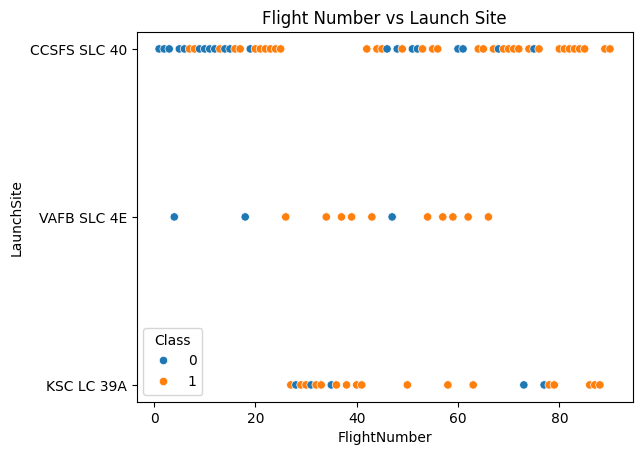

In [10]:
#Flight Number vs Launch Site
sns.scatterplot(x="FlightNumber", y="LaunchSite", hue="Class", data=df)
plt.title("Flight Number vs Launch Site")
plt.show()

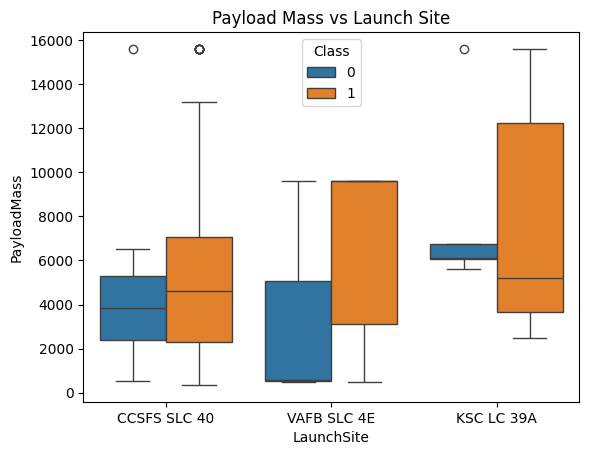

In [11]:
# TASK 2: Payload Mass vs Launch Site
sns.boxplot(x="LaunchSite", y="PayloadMass", hue="Class", data=df)
plt.title("Payload Mass vs Launch Site")
plt.show()

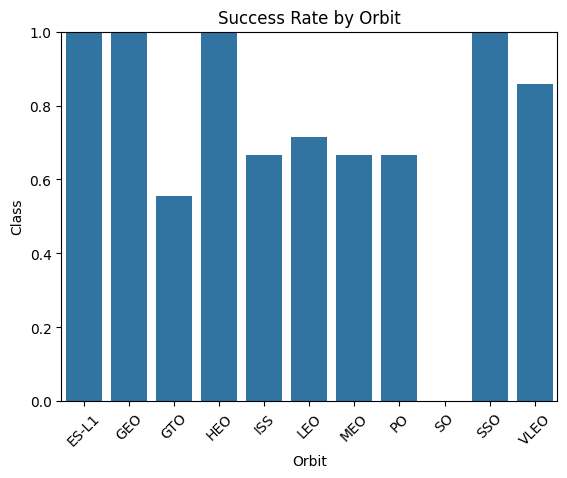

In [12]:
# TASK 3: Success Rate by Orbit Type
orbit_success = df.groupby("Orbit")["Class"].mean().reset_index()
sns.barplot(x="Orbit", y="Class", data=orbit_success)
plt.title("Success Rate by Orbit")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

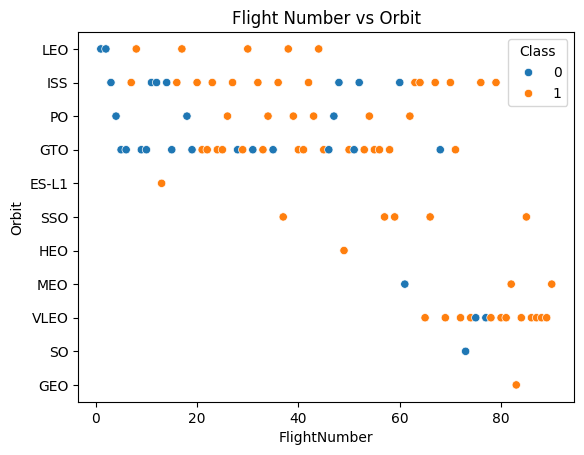

In [13]:
# TASK 4: Flight Number vs Orbit
sns.scatterplot(x="FlightNumber", y="Orbit", hue="Class", data=df)
plt.title("Flight Number vs Orbit")
plt.show()

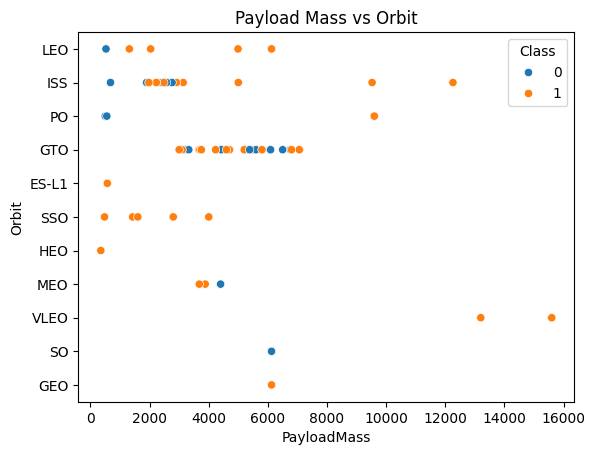

In [14]:
# TASK 5: Payload Mass vs Orbit
sns.scatterplot(x="PayloadMass", y="Orbit", hue="Class", data=df)
plt.title("Payload Mass vs Orbit")
plt.show()

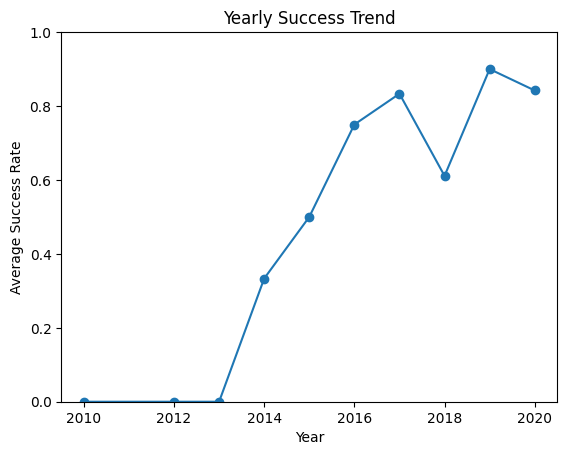

In [15]:
# TASK 6: Yearly Success Trend

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

yearly_success = df.groupby('Year')['Class'].mean().reset_index()
plt.plot(yearly_success['Year'], yearly_success['Class'], marker='o')
plt.title("Yearly Success Trend")
plt.xlabel("Year")
plt.ylabel("Average Success Rate")
plt.ylim(0, 1)
plt.show()
